<a href="https://colab.research.google.com/github/GaPaulino/balanceamento-dados-TCC/blob/main/Balanceamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [10]:
raw_df = pd.read_csv('credit-card.csv')

# **Pré-Processamento dos dados**

Renomeando coluna target

In [11]:
raw_df = raw_df.rename(columns={raw_df.columns[-1]: 'defaulter'})
raw_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaulter
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


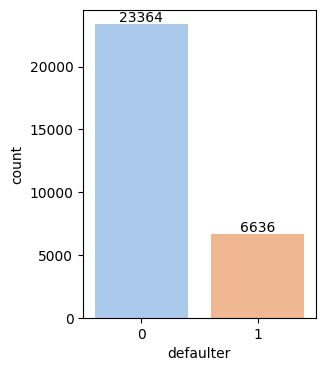

In [12]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='defaulter',data=raw_df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [13]:
print('Compliant:', round(raw_df['defaulter'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Defaulter:', round(raw_df['defaulter'].value_counts()[1]/len(raw_df) * 100,2), '% of the dataset')

Compliant: 77.88 % of the dataset
Defaulter: 22.12 % of the dataset


In [14]:
df = raw_df.copy()

Definindo as variáveis de entrada e de saída

In [15]:
X = df.drop('defaulter', axis=1)
y = df['defaulter']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

Invocando a Validação Cruzada k-fold



In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

#We are going to ensure that we have the same splits of the data every time.
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# **RANDOM FOREST**

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)
#cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

In [19]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.37674919 0.39827772 0.37890205 0.35414424 0.34553283]
Average Cross Validation Recall score: 0.37072120559741656


# **XGBOOST**

In [20]:
xg = XGBClassifier(n_estimators=100, random_state=13, max_depth = 3)
#
score = cross_val_score(xg, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.37567277 0.39827772 0.37782562 0.35952637 0.35844995]
Average Cross Validation Recall score: 0.37395048439181916


In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],          # mais árvores para melhorar estabilidade
    'max_depth': [6, 10, 12],           # incluir árvore ilimitada (None)
    # 'class_weight': ['balanced'],             # essencial para lidar com desbalanceamento
    'random_state': [13]
}

# **GRIDSEARCH RF**

In [22]:
grid_rf = GridSearchCV(rf, param_grid=params, cv=kf,
                          scoring='recall').fit(X_train, y_train)

In [23]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 200, 'random_state': 13}
Best score: 0.367491926803014


In [24]:
y_pred_rf = grid_rf.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred_rf)

rf_Recall = recall_score(y_test, y_pred_rf)
rf_Precision = precision_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[6660  349]
 [1289  702]]


In [26]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.352587,0.667935,0.461538,0.818


# **GRIDSEARCH XGBOOST**

In [27]:
grid_xg = GridSearchCV(xg, param_grid=params, cv=kf,
                          scoring='recall').fit(X_train, y_train)

In [28]:
print('Best parameters:', grid_xg.best_params_)
print('Best score:', grid_xg.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 200, 'random_state': 13}
Best score: 0.37825618945102263


In [29]:
y_pred_xg = grid_xg.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred_xg)

xg_Recall = recall_score(y_test, y_pred_xg)
xg_Precision = precision_score(y_test, y_pred_xg)
xg_f1 = f1_score(y_test, y_pred_xg)
xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[6489  520]
 [1224  767]]


In [31]:
ndf = [(xg_Recall, xg_Precision, xg_f1, xg_accuracy)]

xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
xg_score.insert(0, 'XGBoost with', 'No Under/Oversampling')
xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.385234,0.59596,0.467968,0.806222


# **TÉCNICAS DE BALANCEAMENTO**

# **Random Oversampling RF**



In [32]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [33]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train, y_train)

In [34]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 16355 / 50.0 % of the dataset
Frauds: 16355 / 50.0 % of the dataset


In [35]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [36]:
score2_rf = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2_rf))
print("Average Cross Validation Recall score: {}".format(score2_rf.mean()))

Cross Validation Recall Scores are: [0.43379978 0.45963402 0.43164693 0.42841765 0.41334769]
Average Cross Validation Recall score: 0.4333692142088267


In [37]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [38]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}
Best score: 0.6032292787944027


In [39]:
y_pred_rf = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [40]:
cm = confusion_matrix(y_test, y_pred_rf)

over_rf_Recall = recall_score(y_test, y_pred_rf)
over_rf_Precision = precision_score(y_test, y_pred_rf)
over_rf_f1 = f1_score(y_test, y_pred_rf)
over_rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[5842 1167]
 [ 825 1166]]


In [41]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.585635,0.499786,0.539315,0.778667


# **Random Oversampling XG**

In [42]:
random_overs_pipeline_xg = make_pipeline(RandomOverSampler(random_state=42),
                              XGBClassifier(n_estimators=100, random_state=13, max_depth = 3))

In [43]:
score2_xg = cross_val_score(random_overs_pipeline_xg, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2_xg))
print("Average Cross Validation Recall score: {}".format(score2_xg.mean()))

Cross Validation Recall Scores are: [0.63401507 0.6350915  0.63293864 0.61141012 0.63186222]
Average Cross Validation Recall score: 0.6290635091496233


In [44]:
new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_over_xg = GridSearchCV(random_overs_pipeline_xg, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_xg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_catego...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=13, ...))]),
             param_grid={'xgbclassifier__max_depth': [6, 10, 12],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [45]:
print('Best parameters:', grid_over_xg.best_params_)
print('Best score:', grid_over_xg.best_score_)

Best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__random_state': 13}
Best score: 0.5806243272335845


In [46]:
y_pred_xg = grid_over_xg.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [47]:
cm = confusion_matrix(y_test, y_pred_xg)

over_xg_Recall = recall_score(y_test, y_pred_xg)
over_xg_Precision = precision_score(y_test, y_pred_xg)
over_xg_f1 = f1_score(y_test, y_pred_xg)
over_xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[5700 1309]
 [ 828 1163]]


In [48]:
ndf = [(over_xg_Recall, over_xg_Precision, over_xg_f1, over_xg_accuracy)]

over_xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_xg_score.insert(0, 'XGBoost with', 'Random Oversampling')
over_xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.584129,0.470469,0.521174,0.762556


# **Random Undersampling RF**

In [49]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

In [50]:
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train, y_train)

In [51]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 4645 / 50.0 % of the dataset
Frauds: 4645 / 50.0 % of the dataset


In [52]:
from imblearn.pipeline import Pipeline, make_pipeline

random_under_pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [53]:
score3_rf = cross_val_score(random_under_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3_rf))
print("Average Cross Validation Recall score: {}".format(score3_rf.mean()))

Cross Validation Recall Scores are: [0.6393972  0.65016146 0.64155005 0.64585576 0.63078579]
Average Cross Validation Recall score: 0.6415500538213132


In [54]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_under_rf = GridSearchCV(random_under_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_under_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [55]:
print('Best parameters:', grid_under_rf.best_params_)
print('Best score:', grid_under_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.6316469321851453


In [56]:
y_pred_rf = grid_under_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [57]:
cm = confusion_matrix(y_test, y_pred_rf)

under_rf_Recall = recall_score(y_test, y_pred_rf)
under_rf_Precision = precision_score(y_test, y_pred_rf)
under_rf_f1 = f1_score(y_test, y_pred_rf)
under_rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[5530 1479]
 [ 754 1237]]


In [58]:
ndf = [(under_rf_Recall, under_rf_Precision, under_rf_f1, under_rf_accuracy)]

under_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
under_rf_score.insert(0, 'Random Forest with', 'Random undersampling')
under_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random undersampling,0.621296,0.455449,0.5256,0.751889


# **Random Undersampling XG**

In [59]:
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train, y_train)

In [60]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 4645 / 50.0 % of the dataset
Frauds: 4645 / 50.0 % of the dataset


In [61]:
random_under_pipeline_xg = make_pipeline(RandomUnderSampler(random_state=42),
                              XGBClassifier(n_estimators=100, random_state=13, max_depth = 3))

In [62]:
score3_xg = cross_val_score(random_under_pipeline_xg, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3_xg))
print("Average Cross Validation Recall score: {}".format(score3_xg.mean()))

Cross Validation Recall Scores are: [0.66092573 0.66092573 0.64262648 0.62970936 0.65662002]
Average Cross Validation Recall score: 0.6501614639397202


In [63]:
new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_under_xg = GridSearchCV(random_under_pipeline_xg, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_under_xg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_cate...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=13, ...))]),
             param_grid={'xgbclassifier__max_depth': [6, 10, 12],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [64]:
print('Best parameters:', grid_under_xg.best_params_)
print('Best score:', grid_under_xg.best_score_)

Best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__random_state': 13}
Best score: 0.6628632938643703


In [65]:
y_pred_xg = grid_under_xg.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_pred_xg)

under_xg_Recall = recall_score(y_test, y_pred_xg)
under_xg_Precision = precision_score(y_test, y_pred_xg)
under_xg_f1 = f1_score(y_test, y_pred_xg)
under_xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[5083 1926]
 [ 704 1287]]


In [67]:
ndf = [(under_xg_Recall, under_xg_Precision, under_xg_f1, under_xg_accuracy)]

under_xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
under_xg_score.insert(0, 'XGBoost with', 'Random undersampling')
under_xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,Random undersampling,0.646409,0.40056,0.49462,0.707778


# **SMOTE RF**

In [68]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [69]:
# fit and apply the transform
X_over, y_over = smote.fit_resample(X_train, y_train)

In [70]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 16355 / 50.0 % of the dataset
Frauds: 16355 / 50.0 % of the dataset


In [71]:
from imblearn.pipeline import Pipeline, make_pipeline

smote_pipeline = make_pipeline(SMOTE(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))

In [72]:
score4_rf = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score4_rf))
print("Average Cross Validation Recall score: {}".format(score4_rf.mean()))

Cross Validation Recall Scores are: [0.48869752 0.48439182 0.49838536 0.47255113 0.45855759]
Average Cross Validation Recall score: 0.4805166846071044


In [73]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_smote_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_smote_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [74]:
print('Best parameters:', grid_smote_rf.best_params_)
print('Best score:', grid_smote_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.5556512378902044


In [75]:
y_pred_rf = grid_smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [76]:
cm = confusion_matrix(y_test, y_pred_rf)

smote_rf_Recall = recall_score(y_test, y_pred_rf)
smote_rf_Precision = precision_score(y_test, y_pred_rf)
smote_rf_f1 = f1_score(y_test, y_pred_rf)
smote_rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[5889 1120]
 [ 885 1106]]


In [77]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'Smote')
smote_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Smote,0.5555,0.496855,0.524544,0.777222


# **Smote XG**

In [78]:
# fit and apply the transform
X_over, y_over = smote.fit_resample(X_train, y_train)

In [79]:
from imblearn.pipeline import Pipeline, make_pipeline

smote_pipeline_xg = make_pipeline(SMOTE(random_state=42),
                              XGBClassifier(n_estimators=100, random_state=13, max_depth = 3))

In [80]:
score4_xg = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score4_xg))
print("Average Cross Validation Recall score: {}".format(score4_xg.mean()))

Cross Validation Recall Scores are: [0.48869752 0.48439182 0.49838536 0.47255113 0.45855759]
Average Cross Validation Recall score: 0.4805166846071044


In [81]:
new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_smote_xg = GridSearchCV(smote_pipeline_xg, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_smote_xg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=13, ...))]),
             param_grid={'xgbclassifier__max_depth': [6, 10, 12],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [82]:
print('Best parameters:', grid_smote_xg.best_params_)
print('Best score:', grid_smote_xg.best_score_)

Best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__random_state': 13}
Best score: 0.47922497308934336


In [83]:
y_pred_xg = grid_smote_xg.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [84]:
cm = confusion_matrix(y_test, y_pred_xg)

smote_xg_Recall = recall_score(y_test, y_pred_xg)
smote_xg_Precision = precision_score(y_test, y_pred_xg)
smote_xg_f1 = f1_score(y_test, y_pred_xg)
smote_xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[6030  979]
 [1037  954]]


In [85]:
ndf = [(smote_xg_Recall, smote_xg_Precision, smote_xg_f1, smote_xg_accuracy)]

smote_xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_xg_score.insert(0, 'XGBoost with', 'Smote')
smote_xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,Smote,0.479156,0.493533,0.486239,0.776


# **Tomek Links RF**

In [86]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='auto')

In [87]:
# fit and apply the transform
X_under, y_under = tl.fit_resample(X_train, y_train)

In [88]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 15021 / 76.38 % of the dataset
Frauds: 4645 / 23.62 % of the dataset


In [89]:
from imblearn.pipeline import Pipeline, make_pipeline

tl_pipeline = make_pipeline(TomekLinks(sampling_strategy='auto'),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [90]:
score5_rf = cross_val_score(tl_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score5_rf))
print("Average Cross Validation Recall score: {}".format(score5_rf.mean()))

Cross Validation Recall Scores are: [0.40688913 0.42841765 0.401507   0.38428418 0.37459634]
Average Cross Validation Recall score: 0.3991388589881594


In [91]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_tl_rf = GridSearchCV(tl_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_tl_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tomeklinks', TomekLinks()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [92]:
print('Best parameters:', grid_tl_rf.best_params_)
print('Best score:', grid_tl_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.38815931108719054


In [93]:
y_pred_rf = grid_tl_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [94]:
cm = confusion_matrix(y_test, y_pred_rf)

tl_rf_Recall = recall_score(y_test, y_pred_rf)
tl_rf_Precision = precision_score(y_test, y_pred_rf)
tl_rf_f1 = f1_score(y_test, y_pred_rf)
tl_rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[6605  404]
 [1254  737]]


In [95]:
ndf = [(tl_rf_Recall, tl_rf_Precision, tl_rf_f1, tl_rf_accuracy)]

tl_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
tl_rf_score.insert(0, 'Random Forest with', 'Tomek Links')
tl_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Tomek Links,0.370166,0.645925,0.470626,0.815778


# **Tomek Links XG**

In [96]:
X_under, y_under = tl.fit_resample(X_train, y_train)

In [97]:
from imblearn.pipeline import Pipeline, make_pipeline

tl_pipeline_xg = make_pipeline(TomekLinks(sampling_strategy='auto'),
                              XGBClassifier(n_estimators=100, random_state=13, max_depth = 3))

In [98]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 15021 / 76.38 % of the dataset
Frauds: 4645 / 23.62 % of the dataset


In [99]:
score5_xg = cross_val_score(tl_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score5_xg))
print("Average Cross Validation Recall score: {}".format(score5_xg.mean()))

Cross Validation Recall Scores are: [0.40688913 0.42841765 0.401507   0.38428418 0.37459634]
Average Cross Validation Recall score: 0.3991388589881594


In [100]:
new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_tl_xg = GridSearchCV(tl_pipeline_xg, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_tl_xg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tomeklinks', TomekLinks()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=13, ...))]),
             param_grid={'xgbclassifier__max_depth': [6, 10, 12],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [101]:
print('Best parameters:', grid_tl_xg.best_params_)
print('Best score:', grid_tl_xg.best_score_)

Best parameters: {'xgbclassifier__max_depth': 12, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__random_state': 13}
Best score: 0.40775026910656614


In [102]:
y_pred_xg = grid_tl_xg.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [103]:
cm = confusion_matrix(y_test, y_pred_xg)

tl_xg_Recall = recall_score(y_test, y_pred_xg)
tl_xg_Precision = precision_score(y_test, y_pred_xg)
tl_xg_f1 = f1_score(y_test, y_pred_xg)
tl_xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[6409  600]
 [1155  836]]


In [104]:
ndf = [(tl_xg_Recall, tl_xg_Precision, tl_xg_f1, tl_xg_accuracy)]

tl_xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
tl_xg_score.insert(0, 'XGBoost with', 'Tomek Links')
tl_xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,Tomek Links,0.41989,0.582173,0.48789,0.805


# **SMOTETOMEK RF**

In [105]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

In [106]:
X_smt, y_smt = smt.fit_resample(X_train, y_train)
#

In [107]:
print('Genuine:', y_smt.value_counts()[0], '/', round(y_smt.value_counts()[0]/len(y_smt) * 100,2), '% of the dataset')
print('Frauds:', y_smt.value_counts()[1], '/',round(y_smt.value_counts()[1]/len(y_smt) * 100,2), '% of the dataset')

Genuine: 15914 / 50.0 % of the dataset
Frauds: 15914 / 50.0 % of the dataset


In [108]:
from imblearn.pipeline import Pipeline, make_pipeline

smt_pipeline = make_pipeline(SMOTETomek(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))

In [109]:
score6_rf = cross_val_score(smt_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score6_rf))
print("Average Cross Validation Recall score: {}".format(score6_rf.mean()))

Cross Validation Recall Scores are: [0.49300323 0.50699677 0.50699677 0.47039828 0.45748116]
Average Cross Validation Recall score: 0.48697524219590954


In [110]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_smt_rf = GridSearchCV(smt_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_smt_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smotetomek',
                                        SMOTETomek(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [111]:
print('Best parameters:', grid_smt_rf.best_params_)
print('Best score:', grid_smt_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}
Best score: 0.5575888051668461


In [112]:
y_pred_rf = grid_smt_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [113]:
cm = confusion_matrix(y_test, y_pred_rf)

smt_rf_Recall = recall_score(y_test, y_pred_rf)
smt_rf_Precision = precision_score(y_test, y_pred_rf)
smt_rf_f1 = f1_score(y_test, y_pred_rf)
smt_rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[5829 1180]
 [ 870 1121]]


In [114]:
ndf = [(smt_rf_Recall, smt_rf_Precision, smt_rf_f1, smt_rf_accuracy)]

smt_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smt_rf_score.insert(0, 'Random Forest with', 'SmoteTomek')
smt_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SmoteTomek,0.563034,0.487179,0.522367,0.772222


# **SmoteTomek XG**

In [115]:
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [116]:
from imblearn.pipeline import Pipeline, make_pipeline

smt_pipeline_xg = make_pipeline(SMOTETomek(random_state=42),
                              XGBClassifier(n_estimators=100, random_state=13, max_depth = 3))

In [117]:
score6_xg = cross_val_score(smt_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score6_xg))
print("Average Cross Validation Recall score: {}".format(score6_xg.mean()))

Cross Validation Recall Scores are: [0.49300323 0.50699677 0.50699677 0.47039828 0.45748116]
Average Cross Validation Recall score: 0.48697524219590954


In [118]:
new_params = {'xgbclassifier__' + key: params[key] for key in params}
grid_smt_xg = GridSearchCV(smt_pipeline_xg, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_smt_xg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smotetomek',
                                        SMOTETomek(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      ev...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=13, ...))]),
             param_grid={'xgbclassifier__max_depth': [6, 10, 12],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [119]:
print('Best parameters:', grid_smt_xg.best_params_)
print('Best score:', grid_smt_xg.best_score_)

Best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__random_state': 13}
Best score: 0.4833153928955866


In [120]:
y_pred_xg = grid_smt_xg.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [121]:
cm = confusion_matrix(y_test, y_pred_xg)

smt_xg_Recall = recall_score(y_test, y_pred_xg)
smt_xg_Precision = precision_score(y_test, y_pred_xg)
smt_xg_f1 = f1_score(y_test, y_pred_xg)
smt_xg_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[5993 1016]
 [1033  958]]


In [122]:
ndf = [(smt_xg_Recall, smt_xg_Precision, smt_xg_f1, smt_xg_accuracy)]

smt_xg_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smt_xg_score.insert(0, 'XGBoost with', 'SmoteTomek')
smt_xg_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,SmoteTomek,0.481165,0.485309,0.483228,0.772333


# **Class Weights RF**

In [123]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [124]:
score7_rf = cross_val_score(rfb, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score7_rf))
print("Average Cross Validation Recall score: {}".format(score7_rf.mean()))

Cross Validation Recall Scores are: [0.34122713 0.36706136 0.34660926 0.32508073 0.33692142]
Average Cross Validation Recall score: 0.3433799784714747


In [125]:
grid_rfb = GridSearchCV(rfb, param_grid=params, cv=kf,
                          scoring='recall').fit(X_train, y_train)

In [126]:
y_pred_rf = grid_rfb.predict(X_test)

In [127]:
cm = confusion_matrix(y_test, y_pred_rf)

grid_rfb_Recall = recall_score(y_test, y_pred_rf)
grid_rfb_Precision = precision_score(y_test, y_pred_rf)
grid_rfb_f1 = f1_score(y_test, y_pred_rf)
grid_rfb_accuracy = accuracy_score(y_test, y_pred_rf)

print(cm)

[[5841 1168]
 [ 815 1176]]


In [128]:
ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Random Forest with', 'Class weights')
grid_rfb_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Class weights,0.590658,0.501706,0.542561,0.779667


# **Scale pos weight XG**

In [129]:
from collections import Counter
# calculate scale_pos_weight
counter = Counter(y_train)
scale_pos_weight_value = counter[0] / counter[1]

xgb = XGBClassifier(n_estimators=100, random_state=13, max_depth = 3, scale_pos_weight=scale_pos_weight_value)

In [130]:
score7_xg = cross_val_score(xgb, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score7_xg))
print("Average Cross Validation Recall score: {}".format(score7_xg.mean()))

Cross Validation Recall Scores are: [0.64155005 0.64155005 0.63078579 0.61141012 0.62970936]
Average Cross Validation Recall score: 0.6310010764262648


In [131]:
# Since class_weight is not a parameter for XGBoost, remove it from the params dictionary
params_xgb = {
    'n_estimators': [50, 100, 200],          # mais árvores para melhorar estabilidade
    'max_depth': [6, 10, 12],           # incluir árvore ilimitada (None)
    'random_state': [13],
    'scale_pos_weight': [scale_pos_weight_value]
}
grid_xgb = GridSearchCV(xgb, param_grid=params_xgb, cv=kf,
                          scoring='recall').fit(X_train, y_train)

In [132]:
y_pred_xg = grid_xgb.predict(X_test)

In [133]:
cm = confusion_matrix(y_test, y_pred_xg)

grid_xgb_Recall = recall_score(y_test, y_pred_xg)
grid_xgb_Precision = precision_score(y_test, y_pred_xg)
grid_xgb_f1 = f1_score(y_test, y_pred_xg)
grid_xgb_accuracy = accuracy_score(y_test, y_pred_xg)

print(cm)

[[5617 1392]
 [ 799 1192]]


In [134]:
ndf = [(grid_xgb_Recall, grid_xgb_Precision, grid_xgb_f1, grid_xgb_accuracy)]

grid_xgb_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_score.insert(0, 'XGBoost with', 'Scale Pos Weight')
grid_xgb_score

,XGBoost with,Recall,Precision,F1 Score,Accuracy
0,Scale Pos Weight,0.598694,0.4613,0.521093,0.756556


# **Comparação de Performance**

In [135]:
predictions = pd.concat([rf_score, xg_score, over_rf_score, over_xg_score, under_rf_score, under_xg_score, smote_rf_score, smote_xg_score, tl_rf_score, tl_xg_score, smt_rf_score, smt_xg_score, grid_rfb_score, grid_xgb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,Accuracy,XGBoost with
5,NaN,0.646409,0.400560,0.494620,0.707778,Random undersampling
4,Random undersampling,0.621296,0.455449,0.525600,0.751889,NaN
13,NaN,0.598694,0.461300,0.521093,0.756556,Scale Pos Weight
12,Class weights,0.590658,0.501706,0.542561,0.779667,NaN
2,Random Oversampling,0.585635,0.499786,0.539315,0.778667,NaN
3,NaN,0.584129,0.470469,0.521174,0.762556,Random Oversampling
10,SmoteTomek,0.563034,0.487179,0.522367,0.772222,NaN
6,Smote,0.555500,0.496855,0.524544,0.777222,NaN
11,NaN,0.481165,0.485309,0.483228,0.772333,SmoteTomek
7,NaN,0.479156,0.493533,0.486239,0.776000,Smote


# **AUC-ROC RF**

In [138]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred_xg)
print(f"AUC-ROC Curve for XGBoost with Random Undersampling: {ROCAUCscore:.4f}")

AUC-ROC Curve for XGBoost with Random Undersampling: 0.7000


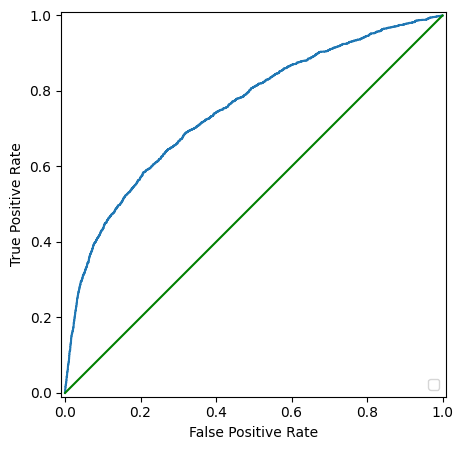

In [139]:
y_proba = grid_under_xg.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)